* Reference
https://pycaret.org/

In [65]:
# lightgbmのバージョンを下げる必要あり
#!pip install pycaret
#!pip install lightgbm==2.2.3

In [2]:
import pandas as pd
import numpy as np
import scipy
import datetime
import os
import re
import sys

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from pycaret.classification import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

from datetime import datetime, date
from collections import defaultdict

import warnings
from tqdm import tqdm
if not sys.warnoptions:
    warnings.simplefilter("ignore") 

In [3]:
#96ut.comからIPOデータを取得(2001年から2019年、1794件)
ipo_urls = ['https://96ut.com/ipo/list.php?year={}'.format(str(i)) for i in range(2001, 2020)]
df_ipo = pd.DataFrame(columns = ["code","銘柄名","主幹","上場","市場","想定(仮条件)","公募","吸収金額","評価","初値","(騰落率)損益","現在値(差分)"])
for urls in tqdm(ipo_urls):
    df_ipo = df_ipo.append(pd.read_html(urls))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  5.47it/s]


In [4]:
#indexを銘柄コードに
df_ipo = df_ipo.set_index('code')
#確認
df_ipo.head()

,銘柄名,主幹,上場,市場,想定(仮条件),公募,吸収金額,評価,初値,(騰落率)損益,現在値(差分)
code,,,,,,,,,,,
4334,ユークス,日興,12/21,NJS,-(),880,8.80億,-(),950,"(+8.0%) +70,000円",315 分割 2倍 (-320)
8902,パシフィックホールディングス,野村,12/21,JQ,-(),250000,5.12億,-(),650000,"(+160.0%) +400,000円","95 (-649,905)"
6738,東研,みずほ,12/21,JQ,-(),600,5.10億,-(),650,"(+8.3%) +50,000円",-
9447,丸紅テレコム,日興,12/20,東2,-(),93000,19.5億,-(),66500,"(-28.5%) -26,500円",-
4335,アイ・ピー・エス,三菱,12/20,JQ,-(),360000,2.16億,-(),1350000,"(+275.0%) +990,000円","591 分割 500倍 (-1,054,500)"


In [5]:
#幹事
#lead = df_ipo['主幹'].value_counts()
#print(lead)

In [6]:
#主幹事が多いほど期待が大きい⇒主幹事数のカラム追加
#print(df_ipo.query('主幹 == "野村 三菱 大和 みずほ 日興 岡三 東海東京"'))

In [7]:
#上場日
#listed_month = df_ipo['上場'].str[:2].value_counts()
#print(listed_month)

In [8]:
#plt.plot(listed_month.sort_index())

In [9]:
#市場⇒東１以下はまとめていいかな
#market = df_ipo['市場'].value_counts()
#print(market)

In [10]:
#想定(仮条件)⇒要加工
#tentatively = df_ipo['想定(仮条件)'].value_counts()
#print(tentatively)

In [11]:
#公募
#public = df_ipo['公募'].value_counts()
#print(public)

In [12]:
#吸収金額
#absorption = df_ipo['吸収金額'].str.strip('億').value_counts()
#print(absorption)

In [13]:
#評価
#evaluation = df_ipo['評価'].value_counts()
#print(evaluation)

In [14]:
#初値⇒-になっているものは除く
#opening = df_ipo['初値'].value_counts()
#print(opening)

In [15]:
#損益⇒加工めんどいし初値を公募価格で割ればいいか
#pl = df_ipo['(騰落率)損益'].value_counts()
#print(pl)

In [16]:
#データ加工
#'(騰落率)損益', '現在値(差分)'を削除
dataset = df_ipo.drop(columns=['(騰落率)損益', '現在値(差分)','銘柄名'])

In [17]:
#初値が-になっているものを削除
dataset = dataset[dataset["初値"] != "-"]

In [18]:
#主幹事数のカラムを追加
def count_lead_secretary(x):
    y = int(str(x).count(" "))+1
    return y

In [19]:
#主幹事数のカラムを追加
dataset["主幹事数"] = dataset['主幹'].apply(count_lead_secretary)
dataset= dataset.drop("主幹",axis=1)

In [20]:
#上場月カラム追加
dataset["上場月"] = dataset['上場'].str[:2]
dataset = dataset.drop("上場",axis=1)

In [21]:
#市場をまとめる
def func_cate(x):
    if x == "東M":
        return x
    elif x == "JQ":
        return x
    elif x == "東2":
        return x
    elif x == "JQS":
        return x
    elif x == "東1":
        return x
    else:
        return 'その他'

dataset['市場'] =dataset['市場'].apply(func_cate)

In [22]:
#仮条件を抽出
dataset = pd.concat([dataset, dataset['想定(仮条件)'].apply(lambda st: st[st.find("(")+1:st.find(")")]).str.split('-', expand=True)], axis=1).drop('想定(仮条件)', axis=1)

In [23]:
dataset.rename(columns={0: '仮条件下限', 1: '仮条件上限'}, inplace=True)
dataset=dataset.dropna()

In [24]:
dataset["仮条件下限"] = dataset["仮条件下限"].str.replace('k', '000')
dataset["仮条件下限"] = dataset["仮条件下限"].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
dataset["仮条件上限"] = dataset["仮条件上限"].str.replace('k', '000')
dataset["仮条件上限"] = dataset["仮条件上限"].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))

In [25]:
dataset["仮条件幅"] = dataset["仮条件上限"] - dataset["仮条件下限"]

In [26]:
#公募をintに
dataset['公募'] = dataset['公募'].astype(int)

In [27]:
#吸収金額をfloatに
dataset['吸収金額'] = dataset['吸収金額'].str.strip('億').astype(float)

In [28]:
#初値をintに
dataset["初値"] = dataset["初値"].astype(int)

In [29]:
#上場市場評価をone hot encoding
#dataset = pd.get_dummies(dataset, drop_first=True,columns=["上場月","市場","評価"])
#カテゴリに指定
cate_cols = ["上場月","市場","評価"]

In [30]:
"""
#カテゴリに変換
for column in cate_cols:
    le = preprocessing.LabelEncoder()
    le.fit(dataset[column])
    dataset[column] = le.transform(dataset[column])
    dataset[column] = dataset[column].astype('category')
    
dataset.head()
"""

"\n#カテゴリに変換\nfor column in cate_cols:\n    le = preprocessing.LabelEncoder()\n    le.fit(dataset[column])\n    dataset[column] = le.transform(dataset[column])\n    dataset[column] = dataset[column].astype('category')\n    \ndataset.head()\n"

In [31]:
#危険シグナルラベルを作る
def kiken_label(x):
    if  x > 0:
        return 0
    else:
        return 1

dataset["危険シグナル"] = dataset["初値"] - dataset["公募"]
dataset["危険シグナル"] = dataset["危険シグナル"].apply(kiken_label)
dataset = dataset.drop(columns=['初値'])

In [32]:
#特徴量追加
dataset["公募-仮上限"] = dataset['公募'] - dataset["仮条件上限"]
dataset["株数"] = dataset['吸収金額'] / dataset["公募"] * 100000000

In [33]:
# 18%はけ危険銘柄
sum(dataset["危険シグナル"])/len(dataset)

0.1827262044653349

In [66]:
dataset = dataset.reset_index()
dataset

,code,市場,公募,吸収金額,評価,主幹事数,上場月,仮条件下限,仮条件上限,仮条件幅,危険シグナル,公募-仮上限,株数
0,8952,その他,525000,840.00,-(),1,09,475000,525000,50000,0,0,160000.000000
1,8951,その他,625000,625.00,-(),1,09,550000,625000,75000,1,0,100000.000000
2,2347,東M,170000,5.10,-(),1,12,140000,170000,30000,1,0,3000.000000
3,2756,JQ,400,3.20,-(),1,12,400,500,100,0,-100,800000.000000
4,8910,JQ,130000,2.80,-(),1,12,120000,150000,30000,0,-20000,2153.846154
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,4430,東2,1500,10.30,C(5),1,02,1410,1500,90,0,0,686666.666667
1698,4429,東M,4000,11.70,A(9),1,02,3840,4000,160,0,0,292500.000000
1699,7049,東M,1800,6.83,A(9),1,02,1640,1800,160,0,0,379444.444444
1700,9286,その他,92000,86.90,D(3),1,02,92000,92000,0,1,0,94456.521739


In [67]:
# trainとtestで分ける
data = dataset.sample(frac =0.8, random_state = 42)
data_test = dataset.drop(data.index)
print('Data for Modeling: ' + str(data.shape))
print('Test Data For Predictions: ' + str(data_test.shape))

Data for Modeling: (1362, 13)
Test Data For Predictions: (340, 13)


In [72]:
# 前処理(ignore_featuresでcodeを無視する)
exp1 = setup(data, target = '危険シグナル', ignore_features=["code"])

 
Setup Succesfully Completed!


,Description,Value
0,session_id,438
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(1362, 13)"
4,Missing Values,False
5,Numeric Features,8
6,Categorical Features,4
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [73]:
# モデルの比較
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extreme Gradient Boosting,0.861500,0.852300,0.391500,0.741000,0.505500,0.434900
1,Gradient Boosting Classifier,0.857300,0.845800,0.403600,0.716400,0.505300,0.430700
2,Ada Boost Classifier,0.851000,0.834400,0.381000,0.677100,0.482300,0.404000
3,Ridge Classifier,0.843700,0.000000,0.240200,0.757200,0.355700,0.294800
4,Random Forest Classifier,0.843700,0.797300,0.335300,0.691100,0.439000,0.360800
5,CatBoost Classifier,0.841600,0.831300,0.370300,0.644900,0.459000,0.374900
6,Linear Discriminant Analysis,0.839500,0.806800,0.262700,0.673500,0.370900,0.300800
7,Light Gradient Boosting Machine,0.833300,0.811200,0.386300,0.589500,0.460300,0.367100
8,Logistic Regression,0.825900,0.577700,0.129700,0.637100,0.199000,0.154600
9,Extra Trees Classifier,0.818500,0.792900,0.363700,0.536600,0.425800,0.323300


In [81]:
# よさげなモデルを作る
"""
    Logistic Regression         'lr'                   linear_model.LogisticRegression
    K Nearest Neighbour         'knn'                  neighbors.KNeighborsClassifier
    Naives Bayes                'nb'                   naive_bayes.GaussianNB
    Decision Tree               'dt'                   tree.DecisionTreeClassifier
    SVM (Linear)                'svm'                  linear_model.SGDClassifier
    SVM (RBF)                   'rbfsvm'               svm.SVC
    Gaussian Process            'gpc'                  gaussian_process.GPC
    Multi Level Perceptron      'mlp'                  neural_network.MLPClassifier
    Ridge Classifier            'ridge'                linear_model.RidgeClassifier
    Random Forest               'rf'                   ensemble.RandomForestClassifier
    Quadratic Disc. Analysis    'qda'                  discriminant_analysis.QDA
    AdaBoost                    'ada'                  ensemble.AdaBoostClassifier
    Gradient Boosting           'gbc'                  ensemble.GradientBoostingClassifier
    Linear Disc. Analysis       'lda'                  discriminant_analysis.LDA
    Extra Trees Classifier      'et'                   ensemble.ExtraTreesClassifier
    Extreme Gradient Boosting   'xgboost'              xgboost.readthedocs.io
    Light Gradient Boosting     'lightgbm'             github.com/microsoft/LightGBM
    CatBoost Classifier         'catboost'             https://catboost.ai
"""

print('create XGB model')
#XGB = create_model('xgboost')
tune_XGB = tune_model('xgboost',round=10, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.812500,0.814815,0.444444,0.500000,0.470588,0.357143
1,0.791667,0.732906,0.222222,0.400000,0.285714,0.175258
2,0.812500,0.811966,0.388889,0.500000,0.437500,0.327103
3,0.810526,0.791855,0.352941,0.461538,0.400000,0.289867
4,0.842105,0.821267,0.235294,0.666667,0.347826,0.280666
5,0.863158,0.803167,0.411765,0.700000,0.518519,0.444944
6,0.863158,0.852187,0.529412,0.642857,0.580645,0.499797
7,0.800000,0.739538,0.388889,0.466667,0.424242,0.304432
8,0.884211,0.876623,0.444444,0.888889,0.592593,0.533690
9,0.821053,0.826118,0.388889,0.538462,0.451613,0.348002


In [83]:
# lr高すぎでは・・・
tune_XGB.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.89,
 'max_delta_step': 0,
 'max_depth': 100,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 50,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 438,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 0}

In [84]:
#print('create CB model')
#CB = create_model('catboost')
#tune_CB = tune_model('catboost')

In [85]:
#tune_CB.get_params()

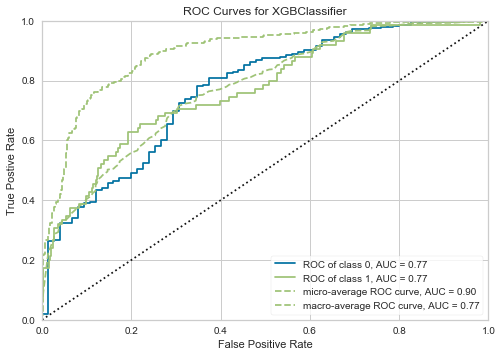

In [86]:
# モデルの可視化
plot_model(tune_XGB)

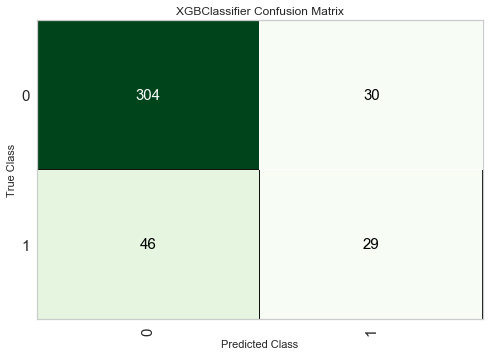

In [87]:
# Confusion Matlix
plot_model(tune_XGB, plot = 'confusion_matrix')

In [88]:
# モデルの評価
evaluate_model(tune_XGB)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [89]:
# 予測
final_xgb = finalize_model(tune_XGB)
xgb_pred = predict_model(final_xgb, data=data_test)

In [90]:
xgb_pred.head()

,code,市場,公募,吸収金額,評価,主幹事数,上場月,仮条件下限,仮条件上限,仮条件幅,危険シグナル,公募-仮上限,株数,Label,Score
0,8951,その他,625000,625.0,-(),1,09,550000,625000,75000,1,0,1.000000e+05,0,0.0153
1,2753,東2,450000,9.9,-(),1,12,420000,500000,80000,1,-50000,2.200000e+03,0,0.3042
2,6432,JQ,720,8.2,-(),1,12,650,750,100,0,-30,1.138889e+06,1,0.9488
3,6731,東M,1700,53.7,-(),1,12,1400,1700,300,0,0,3.158824e+06,0,0.1186
4,2340,JQ,2200,7.7,-(),1,11,1700,2200,500,1,0,3.500000e+05,1,0.6675
